In [2]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

from scipy.fft import fft, fftfreq
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
import os

In [3]:

def run(t_end, changes = {}, *, dt=0.001, path:Path=None, params_set = "abh_values.json"):
    #print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    if params_set == None:
        params = ParameterSet("smallcirtuit.json")
    else:
        params = ParameterSet(params_set)
        print("Params set to", params_set)
    params.batch_update(changes)
    #params.J.print_matrix()
    #params.J_ampa.print_matrix()
    #print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')
        params.saveHtml(path / 'params.html',keys = [])

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    # gen = np.random.Generator(np.random.PCG64(123))
    gen = None
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    #print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

In [4]:
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def max_gamma_power(xf,yf, min_fq=15, max_fq=50):
    limit = np.where((xf<=max_fq)& (xf>=min_fq))
    x_new= xf[limit]
    y_new = yf[limit]
    max_ind = np.argmax(y_new)
    max_freq = x_new[max_ind]
    max_freq_power = y_new[max_ind]
    
    power_gamma_range = sum(y_new)
    return max_freq, max_freq_power,power_gamma_range

def spectrogram( t:np.array, res: list[ModelBase],min_fq=1, max_fq=100, smoothing = None, t_start = 1, t_end=None, **kwargs):
    obj = Plot(['exc1.r'],t_start = t_start, t_end=t_end)
    t_t, traces = obj.get_traces(t, res)
    s = traces[0]
    dt = t[1]-t[0]
    N = len(s)
    yf = fft(s)
    xf = fftfreq(N, dt)[:N//2]
    limit = np.where((xf<=max_fq)& (xf>=min_fq))
    yf = yf[0:N//2]
    if smoothing =="MAF":
        try:
            window_size = kwargs["w"]  # Adjust for more or less smoothing
        except: 
            window_size = 5
            print("window_size not provided. using default value 5")
        smoothed_yf = np.convolve(2.0/N * np.abs(yf[limit]), np.ones(window_size)/window_size, mode='same')

    elif smoothing =="Gauss":
        sigma = 2  # Adjust for more or less smoothing
        smoothed_yf = gaussian_filter1d(2.0/N * np.abs(yf[limit]), sigma)

    elif smoothing=="low pass":        
        fs = 1/dt  # Sampling frequency
        cutoff_freq = 10  # Adjust this based on noise level
        smoothed_yf = lowpass_filter(2.0/N * np.abs(yf[limit]), cutoff_freq, fs)

    else:
        smoothed_yf = 2.0/N * np.abs(yf[limit])
    return xf[limit],smoothed_yf

def smooth_out(yf,smoothing,dt=None,**kwargs):
    if smoothing =="MAF":
        try:
            window_size = kwargs["w"]  # Adjust for more or less smoothing
        except: 
            window_size = 5
            print("window_size not provided. using default value 5")
        smoothed_yf = np.convolve(yf, np.ones(window_size)/window_size, mode='same')

    elif smoothing =="Gauss":
        sigma = 2  # Adjust for more or less smoothing
        smoothed_yf = gaussian_filter1d(yf, sigma)

    elif smoothing=="low pass":        
        fs = 1/dt  # Sampling frequency
        cutoff_freq = 10  # Adjust this based on noise level
        smoothed_yf = lowpass_filter(yf, cutoff_freq, fs)
    return smoothed_yf
        

In [5]:
#function to extract a plot for closing the loop
def fq_curve(I,circuit_params,params_set="ExtendedV1.json",sample_size=30,save_dir=None):
    avg_y=[]
    avg_x=[]
    avg_p=[]
    std_p=[]
    pows=[]
    for i in I:    
        experiment = {"exc1.I_back.dc": i, "exc2.I_back.dc": i}
        experiment.update(circuit_params)
        print(i)
        xs =[]
        ys=[]
        pow = []    
        for j in range(sample_size):
            print(j)
            t, res = run(10, changes = experiment , dt=0.001, path=None, params_set=params_set)
            x,y = spectrogram(t,res,smoothing = None,max_fq= 100)
            pow.append([*max_gamma_power(x,y)])
            xs.append(x)
            ys.append(y)
            
        pows.append(pow)    
        avg_y.append(sum(ys)/sample_size)
        avg_x.append(xs[0])
        avg_p.append(np.average(np.array(pow),axis=0))
        std_p.append(np.std(np.array(pow),axis=0)/sample_size)
        
    avg_x = np.array(avg_x)
    avg_y = np.array(avg_y)
    avg_p = np.array(avg_p)
    std_p = np.array(std_p)
    if save_dir:
        np.save(arr= avg_x ,file=save_dir+"/avg_x.npy")
        np.save(arr= avg_y ,file=save_dir+"/avg_y.npy")
        np.save(arr= avg_p ,file=save_dir+"/avg_p.npy")
        np.save(arr= std_p ,file=save_dir+"/std_p.npy")
        np.save(arr= I, file = save_dir+"/I.npy")
    return avg_p,std_p,avg_x,avg_y

In [ ]:
s= 0.35
v= 0.16
experiment = {"sst1.I_back.dc":s,"sst2.I_back.dc":s,"vip1.I_back.dc":v,"vip2.I_back.dc":v, "J_ampa.vip1.exc1":0, "J_ampa.vip2.exc2":0}
I = np.linspace(0.2,2.0,21)
sample_size=5
J_se=[0.0,0.2]
for i in range(2):
    experiment_name = str(i)
    save_dir = "./freq_curves/closing_loop" + experiment_name
    j_se = J_se[i]
    j_ve= j_se * 1.2
    loop_closing = {"J.sst1.exc1":j_se,"J.sst2.exc2":j_se,"J.vip1.exc1": j_ve, "J.vip2.exc2": j_ve}
    experiment.update(loop_closing)
    os.makedirs(save_dir, exist_ok=True)
    avg_p,std_p,avg_x,avg_y = fq_curve(I,experiment,params_set="Disconnected.json",sample_size=sample_size,save_dir=save_dir)


0.2
0
Params set to Disconnected.json


C:\Users\palavia\AppData\Local\Temp\ipykernel_24584\1686740355.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='Disconnected.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)


1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.29000000000000004
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.38
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.47000000000000003
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.56
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.6499999999999999
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set 

c:\Users\palavia\neural-simulation\src\model_base.py:69: RuntimeWarning: overflow encountered in exp
  den = 1 - np.exp(-p.d * num)
c:\Users\palavia\neural-simulation\src\model_base.py:107: RuntimeWarning: overflow encountered in scalar multiply
  gamma_r *= (1-n.s)
c:\Users\palavia\neural-simulation\src\model_base.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  n_dest._input += n_src.s * p.J.get(src, dest)
c:\Users\palavia\neural-simulation\src\model_base.py:70: RuntimeWarning: invalid value encountered in scalar divide
  return num/den
c:\Users\palavia\neural-simulation\src\model_base.py:62: RuntimeWarning: invalid value encountered in scalar multiply
  v *= 0
c:\Users\palavia\neural-simulation\src\integral.py:87: RuntimeWarning: invalid value encountered in add
  H20 = Yn + fnh # shape (d,)


1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
2.0
0
Params set to Disconnected.json


c:\Users\palavia\neural-simulation\src\integral.py:94: RuntimeWarning: invalid value encountered in add
  Yn1 = Yn + 0.5*(fnh + fn1h) + dg
c:\Users\palavia\neural-simulation\src\model_base.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  n_dest._input += n_src.s_ampa * p.J_ampa.get(src, dest)


1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.2
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.29000000000000004
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.38
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.47000000000000003
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected.json
4
Params set to Disconnected.json
0.56
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
3
Params set to Disconnected

In [6]:
#How to get the difference between json files
params=ParameterSet("img/reduced_circuit_firing_rates/2025-02-17/171956/params.json")
path = Path(".")
params.saveDelta(path / 'params_delta_new_ext.json',base_file='ExtendedV1.json')

C:\Users\palavia\AppData\Local\Temp\ipykernel_24584\2432633081.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='img/reduced_circuit_firing_rates/2025-02-17/171956/params.json' mode='r' encoding='cp1252'>
  params=ParameterSet("img/reduced_circuit_firing_rates/2025-02-17/171956/params.json")
c:\Users\palavia\neural-simulation\src\param.py:69: ResourceWarning: unclosed file <_io.TextIOWrapper name='ExtendedV1.json' mode='r' encoding='cp1252'>
  base = ParameterSet(base_file).__flat_json__()


In [ ]:
I = np.linspace(0.2,2.0,21)
sample_size=5

s= 0.35
v= 0.14
experiment = {"sst1.I_back.dc":s,"sst2.I_back.dc":s,"vip1.I_back.dc":v,"vip2.I_back.dc":v}
experiment_name = "Disconnected"
save_dir = "./freq_curves/" + experiment_name
os.makedirs(save_dir, exist_ok=True)
avg_p,std_p,avg_x,avg_y = fq_curve(I,experiment,params_set="Disconnected.json",sample_size=sample_size,save_dir=save_dir)

0.2
0
Params set to Disconnected.json


C:\Users\palavia\AppData\Local\Temp\ipykernel_24584\1686740355.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='Disconnected.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)


1
Params set to Disconnected.json
2
Params set to Disconnected.json
0.38
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
0.56
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
0.74
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
0.9199999999999999
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
1.0999999999999999
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
1.28
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
1.46
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
1.64
0
Params set to Disconnected.json
1
Params set to Disconnected.json
2
Params set to Disconnected.json
1.8199999999999998
0
Params set to Disconnected.

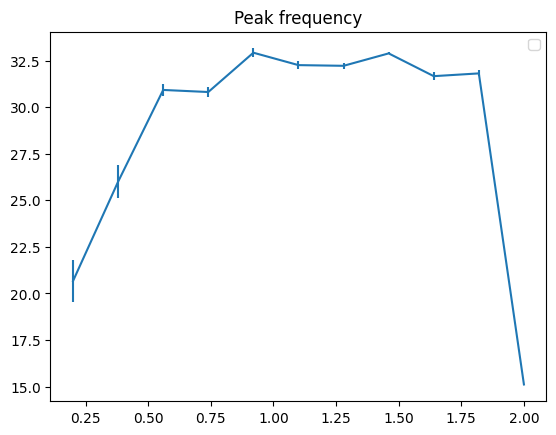

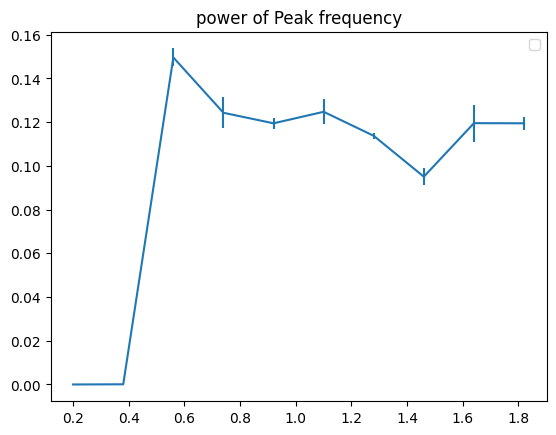

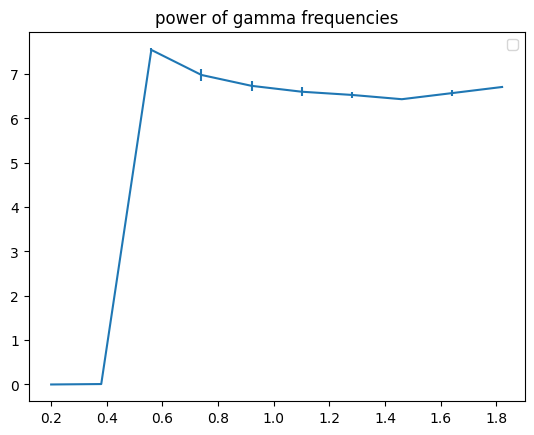

In [12]:

plt.errorbar(I,avg_p[:,0],std_p[:,0])
plt.legend()
plt.title("Peak frequency")
plt.show()

plt.errorbar(I,avg_p[:,1],std_p[:,1])
plt.legend()
plt.title("power of Peak frequency")
plt.show()

plt.errorbar(I,avg_p[:,2],std_p[:,2])
plt.legend()
plt.title("power of gamma frequencies")
plt.show()

In [17]:
experiment = {"exc1.I_back.dc": 1.2, "exc2.I_back.dc": 1.2, "J.exc1.sst1":-0.4, "J.exc2.sst2":-0.4}
t, res = run(10, changes = experiment , dt=0.001, path=None)

C:\Users\palavia\AppData\Local\Temp\ipykernel_12828\1686740355.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='abh_values.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)


Params set to abh_values.json


In [5]:
p = []
x = []
y = []
std_p = []
experiment_names = ["J_ES_0","J_ES_02","J_ES_04"]
for i,en in enumerate(experiment_names):
    save_dir = "./freq_curves/" + en
    p.append(np.load(save_dir+"/avg_p.npy"))
    x.append(np.load(save_dir+"/avg_x.npy"))
    y.append(np.load(save_dir+"/avg_y.npy"))
    std_p.append(np.load(save_dir+"/std_p.npy"))
I= np.load(save_dir+"/I.npy")

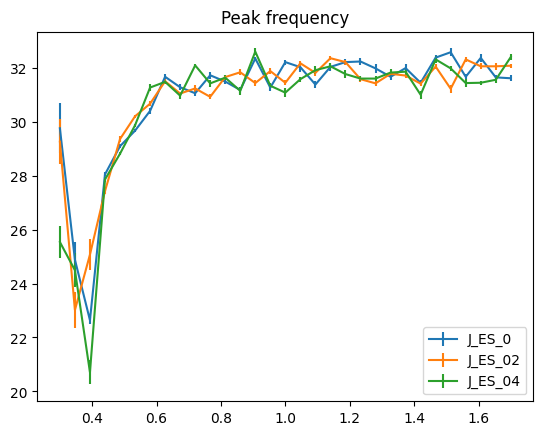

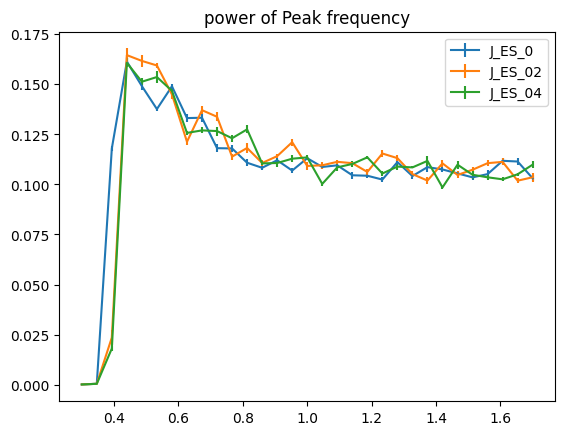

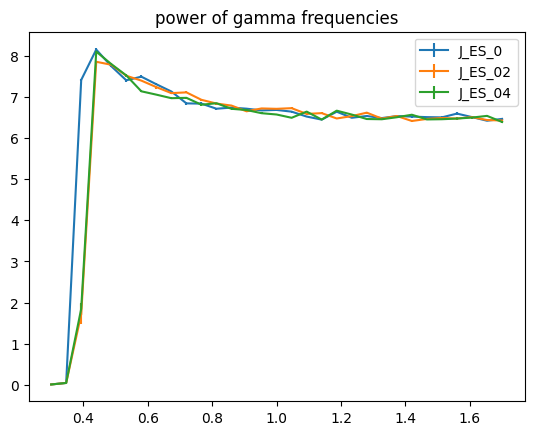

In [10]:
for i,en in enumerate(experiment_names):
    plt.errorbar(I,p[i][:,0],std_p[i][:,0],label = en)
plt.legend()
plt.title("Peak frequency")
plt.show()
for i,en in enumerate(experiment_names):
    plt.errorbar(I,p[i][:,1],std_p[i][:,1],label = en)
plt.legend()
plt.title("power of Peak frequency")
plt.show()
for i,en in enumerate(experiment_names):
    plt.errorbar(I,p[i][:,2],std_p[i][:,2],label = en)
plt.legend()
plt.title("power of gamma frequencies")
plt.show()

0.3
0
Params set to abh_values.json


C:\Users\palavia\AppData\Local\Temp\ipykernel_12828\1686740355.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='abh_values.json' mode='r' encoding='cp1252'>
  params = ParameterSet(params_set)


1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
0.3466666666666667
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
0.3933333333333333
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
0.43999999999999995
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
0.48666666666666664
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
0.5333333333333333
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Param

c:\Users\palavia\neural-simulation\src\model_base.py:69: RuntimeWarning: overflow encountered in exp
  den = 1 - np.exp(-p.d * num)
c:\Users\palavia\neural-simulation\src\model_base.py:107: RuntimeWarning: overflow encountered in scalar multiply
  gamma_r *= (1-n.s)
c:\Users\palavia\neural-simulation\src\model_base.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  n_dest._input += n_src.s * p.J.get(src, dest)
c:\Users\palavia\neural-simulation\src\model_base.py:70: RuntimeWarning: invalid value encountered in scalar divide
  return num/den
c:\Users\palavia\neural-simulation\src\model_base.py:62: RuntimeWarning: invalid value encountered in scalar multiply
  v *= 0
c:\Users\palavia\neural-simulation\src\integral.py:87: RuntimeWarning: invalid value encountered in add
  H20 = Yn + fnh # shape (d,)


1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
1.7
0
Params set to abh_values.json
1
Params set to abh_values.json
2
Params set to abh_values.json
3
Params set to abh_values.json
4
Params set to abh_values.json
